# Chapter 16 Exercises

In [6]:
# From book
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [7]:
import tensorflow as tf
import gym

Use policy gradients to tackle OpenAI gym’s “BypedalWalker-v2”[sic].

Tried this, but the gym.make() for it fails because of some problem with box2d. Others have reported it working on Python 3.4, but not 3.5+. Need a fix, so going to move onto next exercise.

Use the DQN algorithm to train an agent to play Pong, the famous Atari game (Pong-v0 in the OpenAI gym). Beware: an individual observation is insufficient to tell the direction and speed of the ball.

In [3]:
env = gym.make("BipedalWalker-v2")

AttributeError: module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'

In [8]:
env = gym.make("Pong-v0")

Tip from book:

"Games such as Pong or Breakout contain a moving ball whose direction and speed cannot be determined with a single observation, so they would require combining the last few observations into the environment’s state. One way to do that would be to create an image with one channel for each of the last few observations. Alternatively, we could merge the last few observations into a single channel image, for example by computing the max of these observations (after diming the older observations, so that the direction of time is clear on the final image)."

Let's take the latter option.

In [4]:
obs = env.reset()
obs.shape

(210, 160, 3)

In [269]:
env.action_space

Discrete(6)

In [270]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [9]:
# Modified from book
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [8]:
img = preprocess_observation(obs)
img.shape

(80, 80)

<IPython.core.display.Javascript object>


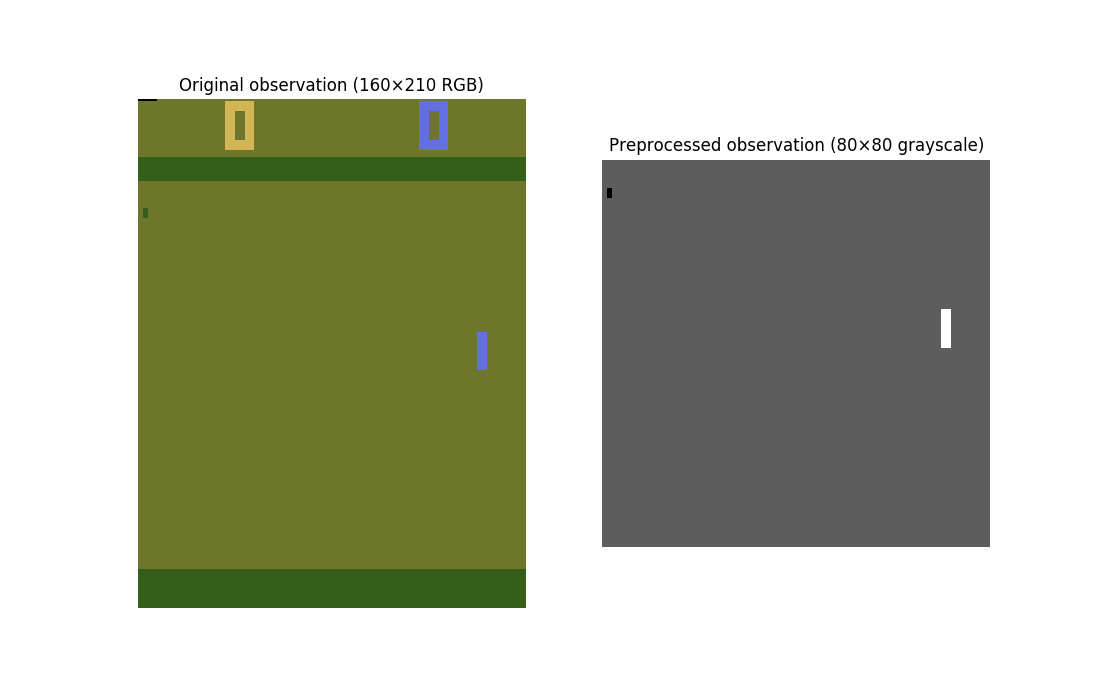

In [9]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [10]:
# Modified from book

from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.8):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(105):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

<IPython.core.display.Javascript object>


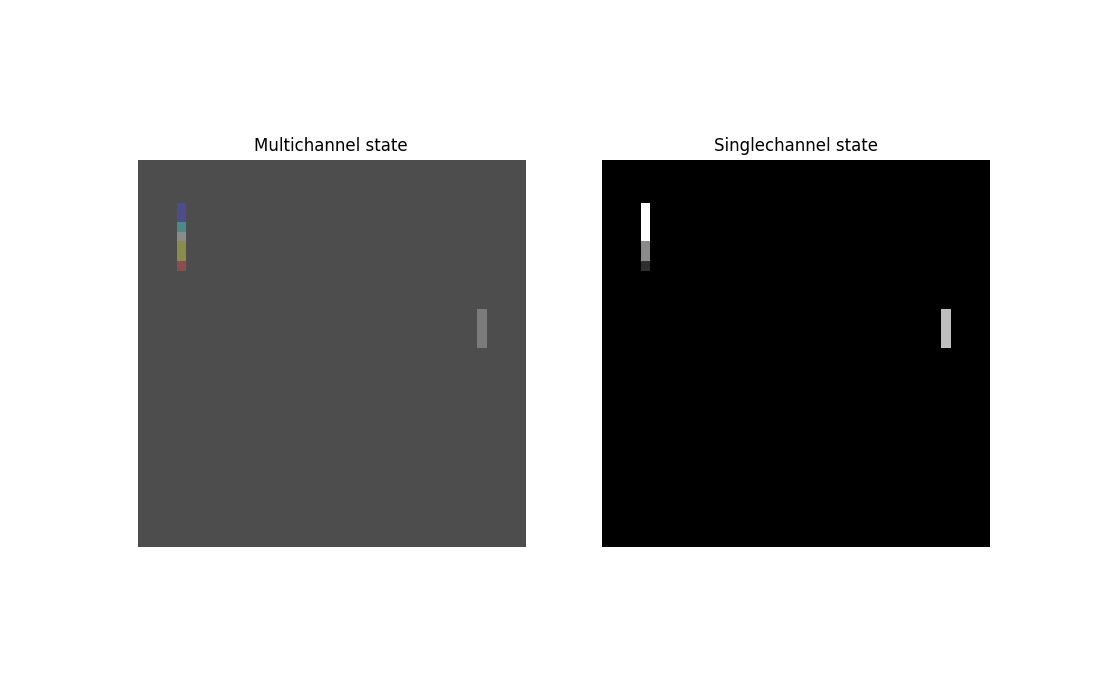

In [11]:
#From book
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1)
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [231]:
# Modified from book
reset_graph()

input_height = 80
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 10 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n - 3  # 6 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [232]:
# Modified from book
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

#####

learning_rate = 0.01
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    #loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    loss = tf.reduce_mean(tf.square(error))

    global_step = tf.Variable(0, trainable=False, name='global_step')
    #optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [6]:
# From book
from collections import deque

replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [234]:
# From book
eps_min = 0.1
eps_max = 1.0
#eps_decay_steps = 2000000
eps_decay_steps = 2000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [235]:
# Modified from book
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.75
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./pong_dqn.ckpt"
done = True # env needs to be reset

In [236]:
# Modified from book
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0
current_reward = 0
max_reward = 0
last_action = 0
count = 0

In [237]:
obs_memory = deque([], maxlen=n_observations_per_state)

In [239]:
# Modified from book
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}\tCurrent Reward {:2f}\t\tMax Reward {:2f}    ".
              format(iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q, current_reward, max_reward), end="")
        if done: # game over, start again
            obs = env.reset()
            obs_memory = deque([], maxlen=n_observations_per_state)
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            for intial in range(2): # get first two initial observations for the memory
                obs, reward, done, info = env.step(0)
                obs_memory.append(preprocess_observation(obs))
            obs_memory.append(preprocess_observation(obs))
            state = combine_observations_singlechannel(obs_memory)
            max_reward = 0
        
        state = state.reshape(80,80,1)
        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)
        action += 1 # remove the 0th option

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        obs_memory.append(preprocess_observation(obs))
        next_state = combine_observations_singlechannel(obs_memory)

        # Let's memorize what happened
        
        if action == last_action:
            count += 1
        else:
            count = 0
            
        if count > 10: # inject negative prior for repeating an action too much
            reward = -10.0
        
        if reward == 1:
            reward = 200
            
        last_action = action
        
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        current_reward = reward
        if current_reward > max_reward:
            max_reward = current_reward

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        X_next_state_val = X_next_state_val.reshape(50,80,80,1)
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 1318	Training step 0/4000000 (0.0)%	Loss   inf	Mean Max-Q -0.032974	Current Reward 0.000000		Max Reward 0.000000    

Iteration 27708	Training step 4427/4000000 (0.1)%	Loss 9.421520	Mean Max-Q 0.218754	Current Reward 0.000000		Max Reward 0.000000          

KeyboardInterrupt: 

In [242]:
# Modified from book
frames = []
n_max_steps = 10000
test_memory = deque([], maxlen=n_observations_per_state)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    
    for intial in range(2): # get first two initial observations for the memory
        obs, reward, done, info = env.step(0)
        test_memory.append(preprocess_observation(obs))
    
    test_memory.append(preprocess_observation(obs))
    state = combine_observations_singlechannel(test_memory)
            
    for step in range(n_max_steps):
        state = state.reshape(80,80,1)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)
        #action = epsilon_greedy(q_values, 0)
        action += 1 # remove the 0th option

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        test_memory.append(preprocess_observation(obs))
        state = combine_observations_singlechannel(test_memory)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./pong_dqn.ckpt


In [243]:
# From book
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


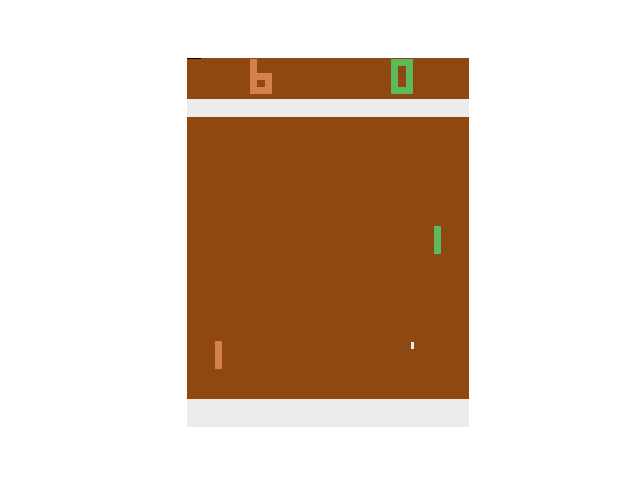

In [244]:
plot_animation(frames)

Can't get DQN to do anything interesting, let's try policy gradients instead.

In [11]:
# Modified from book
reset_graph()

input_height = 80
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 10 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n - 5 # 6 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])

prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
with tf.variable_scope('online_pg_network') as scope:
    for n_maps, kernel_size, strides, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_strides,
            conv_paddings, conv_activation):
        prev_layer = tf.layers.conv2d(
            prev_layer, filters=n_maps, kernel_size=kernel_size,
            strides=strides, padding=padding, activation=activation,
            kernel_initializer=initializer)
    last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
    hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                             activation=hidden_activation,
                             kernel_initializer=initializer)
    logits = tf.layers.dense(hidden, n_outputs)
    outputs = tf.nn.sigmoid(logits)

In [12]:
# Modified from book

learning_rate = 0.01

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
# From book
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [14]:
obs_memory = deque([], maxlen=n_observations_per_state)

In [ ]:
# Modified from book
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            
            obs_memory = deque([], maxlen=n_observations_per_state)
            #for skip in range(skip_start): # skip the start of each game
                #obs, reward, done, info = env.step(0)
            for intial in range(2): # get first two initial observations for the memory
                obs, reward, done, info = env.step(0)
                obs_memory.append(preprocess_observation(obs))
            obs_memory.append(preprocess_observation(obs))
            state = combine_observations_singlechannel(obs_memory)
            
            while True:
                state = state.reshape(1,80,80,1)
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X_state: state})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                obs_memory.append(preprocess_observation(obs))
                state = combine_observations_singlechannel(obs_memory)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 0

In [15]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames